# MSA 8650 Assignment 1: Semantic Segmentaion
In this part, you will design and implement your Convolutional Neural Networks to perform semantic segmentation on the Mini Facade dataset.

Group Members

- : Sagar Mehta LASTNAME, #002649430  //
- : Vineetha Burugupalli, #002581345   //



## Setup
First, we will install some required packages for this notebook and download the Mini Facade dataset. 


In [2]:
# install required packages and download the dataset
!pip install colormap easydev pypng
!wget http://web.eecs.umich.edu/~justincj/teaching/eecs442/resources/facades.zip
!unzip facades.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 2.6 MB/s 
     |████████████████████████████████| 58 kB 4.4 MB/s 
  Created wheel for colormap: filename=colormap-1.0.4-py3-none-any.whl size=15637 sha256=e3f019a64edfa9d9f75f2cfb74ac71d30c2af120d43712f0cf13f495b8a40e4e
  Stored in directory: /root/.cache/pip/wheels/71/35/4b/259c328e39ede29b184e4ffe4443bcc2be4e475178a83794c3
  Created wheel for easydev: filename=easydev-0.12.0-py3-none-any.whl size=64232 sha256=7117dffe90f878d6b08c4b994433bc87892fa62a3054e435c67f2d451eb31f04
  Stored in directory: /root/.cache/pip/wheels/82/ab/83/fdfc4017ea44a585b6754752cc5f63f2d0d63fcc1317e7174b
Successfully built colormap easydev
--2022-10-12 21:35:51--  http://web.eecs.umich.edu/~justincj/teaching/eecs442/resources/facades.zip
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.1

In [3]:
import os
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np
import png
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from PIL import Image
import torchvision
from colormap.colors import Color, hex2rgb
from sklearn.metrics import average_precision_score as ap_score
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import Dataset
from tqdm import tqdm

In [4]:
if torch.cuda.is_available():
    print("Using the GPU. You are good to go!")
    device = torch.device('cuda:0')
else:
    raise Exception("WARNING: Could not find GPU! Using CPU only. \
To enable GPU, please to go Edit > Notebook Settings > Hardware \
Accelerator and select GPU.")

Using the GPU. You are good to go!


## Dataset
We will create a custom Dataset function for the Mini Facade dataset. You don't have to change anything here.

In [5]:
class FacadeDataset(Dataset):
  def __init__(self, flag, dataDir='./facades/', data_range=(0, 8), n_class=5, 
               onehot=False):
    self.onehot = onehot
    assert(flag in ['train', 'eval', 'test', 'test_dev', 'kaggle'])
    print("load "+ flag+" dataset start")
    print("    from: %s" % dataDir)
    print("    range: [%d, %d)" % (data_range[0], data_range[1]))
    self.dataset = []
    for i in range(data_range[0], data_range[1]):
      img = Image.open(os.path.join(dataDir,flag,'eecs442_%04d.jpg' % i))

      pngreader = png.Reader(filename=os.path.join(dataDir,flag,
                                                   'eecs442_%04d.png' % i))
      w,h,row,info = pngreader.read()
      label = np.array(list(row)).astype('uint8')

      # Normalize input image
      img = np.asarray(img).astype("f").transpose(2, 0, 1)/128.0-1.0
      # Convert to n_class-dimensional onehot matrix
      label_ = np.asarray(label)
      label = np.zeros((n_class, img.shape[1], img.shape[2])).astype("i")
      for j in range(n_class):
          label[j, :] = label_ == j
      self.dataset.append((img, label))
    print("load dataset done")

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    img, label = self.dataset[index]
    label = torch.FloatTensor(label)
    if not self.onehot:
      label = torch.argmax(label, dim=0)
    else:
      label = label.long()

    return torch.FloatTensor(img), torch.LongTensor(label)

Now, we will create a dataloader for the Mini Facade dataset. You have to play with the size of train-val split and adjust the batch sizes for the splits.

In [6]:
N_CLASS=5
##############################################################################
# TODO: Change data_range so that train_data and val_data splits the 906     #
# samples under "train" folder. You can decide how to split.                 #
#                                                                            # 
# TODO: Adjust batch_size for loaders                                        #
##############################################################################
train_data = FacadeDataset(flag='train', data_range=(0,750), onehot=False)
train_loader = DataLoader(train_data, batch_size=4)
val_data = FacadeDataset(flag='train', data_range=(750,906), onehot=False)
val_loader = DataLoader(val_data, batch_size=4)
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################
test_data = FacadeDataset(flag='test_dev', data_range=(0,114), onehot=False)
test_loader = DataLoader(test_data, batch_size=1)

# ap_loader for calculating Average Precision
ap_data = FacadeDataset(flag='test_dev', data_range=(0,114), onehot=True)
ap_loader = DataLoader(ap_data, batch_size=1)

load train dataset start
    from: ./facades/
    range: [0, 750)
load dataset done
load train dataset start
    from: ./facades/
    range: [750, 906)
load dataset done
load test_dev dataset start
    from: ./facades/
    range: [0, 114)
load dataset done
load test_dev dataset start
    from: ./facades/
    range: [0, 114)
load dataset done


## Model
Design and implement your Convolutional NeuralNetworks to perform semantic segmentation on the Mini Facade dataset. 

You can build a simple neural network based on the U-net [1]:
1. Conv-ReLU-Conv-ReLU that goes from `3 -> 64 -> 64` ( H x W )
2. Maxpool (`nn.MaxPool2d`) to reduce the size of the feature map by half ( H/2 x W/2 )
3. Conv-ReLU-Conv-ReLU that goes from `64 -> 128 -> 128` ( H/2 x W/2 )
4. Maxpool (`nn.MaxPool2d`) to reduce the size of the feature map by half ( H/4 x W/4 )
5. Conv that goes from `128 -> 128` ( H/4 x W/4 )
6. Upsample (`nn.Upsample`) to increase of size of the feature map by two ( H/2 x W/2 )
6. Conv-ReLU-Conv-ReLU that goes from `128 -> 64 -> 64` ( H/2 x W/2 )
7. Upsample (`nn.Upsample`) to increase of size of the feature map by two ( H x W )
8. Conv-ReLU-Conv-ReLU that goes from `64 -> 64 -> 5` ( H x W )

Be careful while choosing the kernel size, padding and stride in the convolution layer. You can compute the output shape after a convolution by using the formula:

$$
X_{out} = (X_{in} - K + 2P)/S +1
$$

Where, $X_{out}$ & $X_{in}$ are the output and input shape of the feature map and $K$, $P$ & $S$ are the kernel size, padding and stride repectively.

[1] O. Ronneberger, P. Fischer, and T. Brox, “U-net:  Convolutional networks for biomedical image seg-mentation,”ArXiv, vol. abs/1505.04597, 2015

In [7]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.n_class = N_CLASS
    ########################################################################
    # TODO: Implement a sematic segmentation model                         #
    ########################################################################
    self.layers = nn.Sequential(
        #Conv-ReLU-Conv-ReLU that goes from 3 -> 64 -> 64 ( H x W )
        nn.Conv2d(3,64,kernel_size = 3,stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(64,64,3,1,1),
        nn.ReLU(),
        #Maxpool (nn.MaxPool2d) to reduce the size of the feature map by half ( H/2 x W/2 )
        nn.MaxPool2d(2, 2),
        #Conv-ReLU-Conv-ReLU that goes from 64 -> 128 -> 128 ( H/2 x W/2 )
        nn.Conv2d(64,128,kernel_size = 3,stride = 1,padding = 1),
        nn.ReLU(),
        nn.Conv2d(128,128,3,1,1),
        nn.ReLU(),
        #Maxpool (nn.MaxPool2d) to reduce the size of the feature map by half ( H/4 x W/4 )
        nn.MaxPool2d(kernel_size=2, stride=2),
        #Conv that goes from 128 -> 128 ( H/4 x W/4 )
        nn.Conv2d(128,128,3,1,1),
        #Upsample (nn.Upsample) to increase of size of the feature map by two ( H/2 x W/2 )
        nn.Upsample(scale_factor = 2),
        #Conv-ReLU-Conv-ReLU that goes from 128 -> 64 -> 64 ( H/2 x W/2 )
        nn.Conv2d(128,64,kernel_size = 3,stride = 1,padding = 1),
        nn.ReLU(),
        nn.Conv2d(64,64,kernel_size = 3,stride = 1,padding = 1),
        nn.ReLU(),
        #Upsample (nn.Upsample) to increase of size of the feature map by two ( H x W )
        nn.Upsample(scale_factor = 2),
        nn.Conv2d(64,64,kernel_size = 3,stride = 1,padding = 1),
        nn.ReLU(),
        nn.Conv2d(64,5,3,1,1),
        nn.ReLU()
      
        )
    ########################################################################
    #                             END OF YOUR CODE                         #
    ########################################################################

  def forward(self, x):
    ########################################################################
    # TODO: Implement the forward pass                                     #
    ########################################################################
    x = self.layers(x)
    ########################################################################
    #                             END OF YOUR CODE                         #
    ########################################################################
    return x

Ininitialize your model and look at the structure of your model, [torchsummary](https://github.com/sksq96/pytorch-summary) is a useful library to look at the computation graph of your model.

In [8]:
name = 'starter_net'
net = Net().to(device)
# visualizing the model
print('Your network:')
summary(net, (3,224,224))

Your network:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 128, 56, 56]         147,584
         Upsample-12        [-1, 128, 112, 112]               0
           Conv2d-13         [-1, 64, 112, 112]          73,792
             ReLU-14     

Once you have completed the model implementation in the cell above, run the cell below to load helper functions and train the model.

In [9]:
def save_label(label, path):
  '''
  Function for ploting labels.
  '''
  colormap = [
      '#000000',
      '#0080FF',
      '#80FF80',
      '#FF8000',
      '#FF0000',
  ]
  assert(np.max(label)<len(colormap))
  colors = [hex2rgb(color, normalise=False) for color in colormap]
  w = png.Writer(label.shape[1], label.shape[0], palette=colors, bitdepth=4)
  with open(path, 'wb') as f:
      w.write(f, label)

def train(trainloader, net, criterion, optimizer, device, epoch):
  '''
  Function for training.
  '''
  start = time.time()
  running_loss = 0.0
  cnt = 0
  net = net.train()
  for images, labels in tqdm(trainloader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    output = net(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    cnt += 1
  end = time.time()
  running_loss /= cnt
  print('\n [epoch %d] loss: %.3f elapsed time %.3f' %
        (epoch, running_loss, end-start))
  return running_loss

def test(testloader, net, criterion, device):
  '''
  Function for testing.
  '''
  losses = 0.
  cnt = 0
  with torch.no_grad():
    net = net.eval()
    for images, labels in tqdm(testloader):
      images = images.to(device)
      labels = labels.to(device)
      output = net(images)
      loss = criterion(output, labels)
      losses += loss.item()
      cnt += 1
  print('\n',losses / cnt)
  return (losses/cnt)


def cal_AP(testloader, net, criterion, device):
  '''
  Calculate Average Precision
  '''
  losses = 0.
  cnt = 0
  with torch.no_grad():
    net = net.eval()
    preds = [[] for _ in range(5)]
    heatmaps = [[] for _ in range(5)]
    for images, labels in tqdm(testloader):
      images = images.to(device)
      labels = labels.to(device)
      output = net(images).cpu().numpy()
      for c in range(5):
        preds[c].append(output[:, c].reshape(-1))
        heatmaps[c].append(labels[:, c].cpu().numpy().reshape(-1))

    aps = []
    for c in range(5):
      preds[c] = np.concatenate(preds[c])
      heatmaps[c] = np.concatenate(heatmaps[c])
      if heatmaps[c].max() == 0:
        ap = float('nan')
      else:
        ap = ap_score(heatmaps[c], preds[c])
        aps.append(ap)
      print("AP = {}".format(ap))
    print("Average Precision (all classes) = {}".format(np.mean(aps)))
  return None


def get_result(testloader, net, device, folder='output_train'):
  result = []
  cnt = 1
  os.makedirs(folder, exist_ok=True)
  with torch.no_grad():
    net = net.eval()
    cnt = 0
    for images, labels in tqdm(testloader):
      images = images.to(device)
      labels = labels.to(device)
      output = net(images)[0].cpu().numpy()
      c, h, w = output.shape
      assert(c == N_CLASS)
      y = np.argmax(output, 0).astype('uint8')
      gt = labels.cpu().data.numpy().squeeze(0).astype('uint8')
      save_label(y, './{}/y{}.png'.format(folder, cnt))
      save_label(gt, './{}/gt{}.png'.format(folder, cnt))
      plt.imsave('./{}/x{}.png'.format(folder, cnt),
                 ((images[0].cpu().data.numpy()+1)*128).astype(np.uint8).transpose(1,2,0))
      cnt += 1

def plot_hist(trn_hist, val_hist):
    x = np.arange(len(trn_hist))
    plt.figure()
    plt.plot(x, trn_hist)
    plt.plot(x, val_hist)
    plt.legend(['Training', 'Validation'])
    plt.xticks(x)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

Experiment with with different optimizers, parameters (such as learning rate) and number of epochs. We expect you to achieve **0.45 AP** on the test set


Start training
-----------------Epoch = 1-----------------


100%|██████████| 188/188 [00:22<00:00,  8.28it/s]



 [epoch 1] loss: 1.606 elapsed time 22.731
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.16it/s]



 1.4552803864845862
-----------------Epoch = 2-----------------


100%|██████████| 188/188 [00:20<00:00,  9.11it/s]



 [epoch 2] loss: 1.329 elapsed time 20.639
Validation loss: 


100%|██████████| 39/39 [00:03<00:00, 12.75it/s]



 1.2671440167304797
-----------------Epoch = 3-----------------


100%|██████████| 188/188 [00:20<00:00,  9.04it/s]



 [epoch 3] loss: 1.178 elapsed time 20.798
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.12it/s]



 1.0916535946039052
-----------------Epoch = 4-----------------


100%|██████████| 188/188 [00:21<00:00,  8.95it/s]



 [epoch 4] loss: 1.060 elapsed time 21.019
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.24it/s]



 1.030457698381864
-----------------Epoch = 5-----------------


100%|██████████| 188/188 [00:21<00:00,  8.92it/s]



 [epoch 5] loss: 0.993 elapsed time 21.087
Validation loss: 


100%|██████████| 39/39 [00:03<00:00, 10.49it/s]



 0.9793340961138407
-----------------Epoch = 6-----------------


100%|██████████| 188/188 [00:20<00:00,  8.98it/s]



 [epoch 6] loss: 0.952 elapsed time 20.956
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.17it/s]



 0.9365691573191912
-----------------Epoch = 7-----------------


100%|██████████| 188/188 [00:20<00:00,  9.01it/s]



 [epoch 7] loss: 0.923 elapsed time 20.884
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.39it/s]



 0.9247072660006009
-----------------Epoch = 8-----------------


100%|██████████| 188/188 [00:20<00:00,  8.99it/s]



 [epoch 8] loss: 0.901 elapsed time 20.918
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.34it/s]



 0.9005510547222235
-----------------Epoch = 9-----------------


100%|██████████| 188/188 [00:20<00:00,  9.02it/s]



 [epoch 9] loss: 0.875 elapsed time 20.862
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.35it/s]



 0.8743675137177492
-----------------Epoch = 10-----------------


100%|██████████| 188/188 [00:20<00:00,  9.00it/s]



 [epoch 10] loss: 0.850 elapsed time 20.905
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.53it/s]



 0.8482198149729998
-----------------Epoch = 11-----------------


100%|██████████| 188/188 [00:21<00:00,  8.71it/s]



 [epoch 11] loss: 0.831 elapsed time 21.602
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.39it/s]



 0.8448052742542365
-----------------Epoch = 12-----------------


100%|██████████| 188/188 [00:24<00:00,  7.81it/s]



 [epoch 12] loss: 0.818 elapsed time 24.099
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.34it/s]



 0.8269504262850835
-----------------Epoch = 13-----------------


100%|██████████| 188/188 [00:21<00:00,  8.94it/s]



 [epoch 13] loss: 0.804 elapsed time 21.035
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.05it/s]



 0.8136928448310266
-----------------Epoch = 14-----------------


100%|██████████| 188/188 [00:20<00:00,  8.97it/s]



 [epoch 14] loss: 0.795 elapsed time 20.981
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 13.99it/s]



 0.8010482207322732
-----------------Epoch = 15-----------------


100%|██████████| 188/188 [00:21<00:00,  8.64it/s]



 [epoch 15] loss: 0.782 elapsed time 21.764
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.33it/s]



 0.7925041593038119
-----------------Epoch = 16-----------------


100%|██████████| 188/188 [00:21<00:00,  8.94it/s]



 [epoch 16] loss: 0.770 elapsed time 21.047
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.49it/s]



 0.7874587514461615
-----------------Epoch = 17-----------------


100%|██████████| 188/188 [00:21<00:00,  8.66it/s]



 [epoch 17] loss: 0.758 elapsed time 21.726
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.46it/s]



 0.7705331490590022
-----------------Epoch = 18-----------------


100%|██████████| 188/188 [00:21<00:00,  8.95it/s]



 [epoch 18] loss: 0.745 elapsed time 21.015
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.40it/s]



 0.7580452393262814
-----------------Epoch = 19-----------------


100%|██████████| 188/188 [00:20<00:00,  9.00it/s]



 [epoch 19] loss: 0.735 elapsed time 20.902
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.30it/s]



 0.7571052939463885
-----------------Epoch = 20-----------------


100%|██████████| 188/188 [00:21<00:00,  8.95it/s]



 [epoch 20] loss: 0.727 elapsed time 21.024
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.60it/s]



 0.7457584738731384
-----------------Epoch = 21-----------------


100%|██████████| 188/188 [00:20<00:00,  9.04it/s]



 [epoch 21] loss: 0.719 elapsed time 20.804
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.55it/s]



 0.7391883043142465
-----------------Epoch = 22-----------------


100%|██████████| 188/188 [00:21<00:00,  8.74it/s]



 [epoch 22] loss: 0.712 elapsed time 21.522
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.23it/s]



 0.7351660743737832
-----------------Epoch = 23-----------------


100%|██████████| 188/188 [00:21<00:00,  8.82it/s]



 [epoch 23] loss: 0.705 elapsed time 21.333
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.00it/s]



 0.7262892784216465
-----------------Epoch = 24-----------------


100%|██████████| 188/188 [00:21<00:00,  8.94it/s]



 [epoch 24] loss: 0.700 elapsed time 21.038
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.18it/s]



 0.7216186936085041
-----------------Epoch = 25-----------------


100%|██████████| 188/188 [00:20<00:00,  8.96it/s]



 [epoch 25] loss: 0.693 elapsed time 21.000
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.33it/s]



 0.715514967074761
-----------------Epoch = 26-----------------


100%|██████████| 188/188 [00:20<00:00,  9.00it/s]



 [epoch 26] loss: 0.686 elapsed time 20.911
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.39it/s]



 0.714236224308992
-----------------Epoch = 27-----------------


100%|██████████| 188/188 [00:20<00:00,  8.98it/s]



 [epoch 27] loss: 0.682 elapsed time 20.955
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.44it/s]



 0.7199489107498755
-----------------Epoch = 28-----------------


100%|██████████| 188/188 [00:21<00:00,  8.74it/s]



 [epoch 28] loss: 0.678 elapsed time 21.512
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.65it/s]



 0.705758084089328
-----------------Epoch = 29-----------------


100%|██████████| 188/188 [00:21<00:00,  8.66it/s]



 [epoch 29] loss: 0.672 elapsed time 21.713
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.10it/s]



 0.7045018718792841
-----------------Epoch = 30-----------------


100%|██████████| 188/188 [00:21<00:00,  8.95it/s]



 [epoch 30] loss: 0.670 elapsed time 21.024
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.33it/s]



 0.6991483294046842
-----------------Epoch = 31-----------------


100%|██████████| 188/188 [00:20<00:00,  8.99it/s]



 [epoch 31] loss: 0.662 elapsed time 20.918
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.47it/s]



 0.6963787506788205
-----------------Epoch = 32-----------------


100%|██████████| 188/188 [00:21<00:00,  8.95it/s]



 [epoch 32] loss: 0.659 elapsed time 21.018
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.52it/s]



 0.692282403126741
-----------------Epoch = 33-----------------


100%|██████████| 188/188 [00:21<00:00,  8.72it/s]



 [epoch 33] loss: 0.654 elapsed time 21.581
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.21it/s]



 0.6902536917955447
-----------------Epoch = 34-----------------


100%|██████████| 188/188 [00:21<00:00,  8.91it/s]



 [epoch 34] loss: 0.650 elapsed time 21.112
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.33it/s]



 0.6894310193184094
-----------------Epoch = 35-----------------


100%|██████████| 188/188 [00:21<00:00,  8.55it/s]



 [epoch 35] loss: 0.644 elapsed time 22.000
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.24it/s]



 0.6974990444305615
-----------------Epoch = 36-----------------


100%|██████████| 188/188 [00:21<00:00,  8.85it/s]



 [epoch 36] loss: 0.641 elapsed time 21.254
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.52it/s]



 0.6827177619322752
-----------------Epoch = 37-----------------


100%|██████████| 188/188 [00:21<00:00,  8.93it/s]



 [epoch 37] loss: 0.639 elapsed time 21.055
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.43it/s]



 0.6858101960940238
-----------------Epoch = 38-----------------


100%|██████████| 188/188 [00:22<00:00,  8.41it/s]



 [epoch 38] loss: 0.634 elapsed time 22.360
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.26it/s]



 0.6768765846888224
-----------------Epoch = 39-----------------


100%|██████████| 188/188 [00:23<00:00,  8.04it/s]



 [epoch 39] loss: 0.629 elapsed time 23.411
Validation loss: 


100%|██████████| 39/39 [00:03<00:00,  9.79it/s]



 0.6714488833378522
-----------------Epoch = 40-----------------


100%|██████████| 188/188 [00:22<00:00,  8.43it/s]



 [epoch 40] loss: 0.629 elapsed time 22.318
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.25it/s]



 0.6727494169504215
-----------------Epoch = 41-----------------


100%|██████████| 188/188 [00:21<00:00,  8.94it/s]



 [epoch 41] loss: 0.622 elapsed time 21.037
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.32it/s]



 0.6683607025024219
-----------------Epoch = 42-----------------


100%|██████████| 188/188 [00:22<00:00,  8.52it/s]



 [epoch 42] loss: 0.616 elapsed time 22.083
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.36it/s]



 0.6635327079357245
-----------------Epoch = 43-----------------


100%|██████████| 188/188 [00:21<00:00,  8.90it/s]



 [epoch 43] loss: 0.612 elapsed time 21.127
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.08it/s]



 0.6633306267933968
-----------------Epoch = 44-----------------


100%|██████████| 188/188 [00:21<00:00,  8.66it/s]



 [epoch 44] loss: 0.608 elapsed time 21.715
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.22it/s]



 0.669457923143338
-----------------Epoch = 45-----------------


100%|██████████| 188/188 [00:20<00:00,  8.99it/s]



 [epoch 45] loss: 0.605 elapsed time 20.930
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.29it/s]



 0.6596679030320584
-----------------Epoch = 46-----------------


100%|██████████| 188/188 [00:20<00:00,  8.96it/s]



 [epoch 46] loss: 0.601 elapsed time 21.000
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.26it/s]



 0.6577096275794201
-----------------Epoch = 47-----------------


100%|██████████| 188/188 [00:21<00:00,  8.93it/s]



 [epoch 47] loss: 0.596 elapsed time 21.075
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.03it/s]



 0.6567659255785819
-----------------Epoch = 48-----------------


100%|██████████| 188/188 [00:21<00:00,  8.93it/s]



 [epoch 48] loss: 0.603 elapsed time 21.065
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.22it/s]



 0.6592836945484846
-----------------Epoch = 49-----------------


100%|██████████| 188/188 [00:20<00:00,  8.95it/s]



 [epoch 49] loss: 0.593 elapsed time 21.009
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 13.04it/s]



 0.6552533553196833
-----------------Epoch = 50-----------------


100%|██████████| 188/188 [00:21<00:00,  8.62it/s]



 [epoch 50] loss: 0.589 elapsed time 21.810
Validation loss: 


100%|██████████| 39/39 [00:02<00:00, 14.21it/s]



 0.6516664884029291


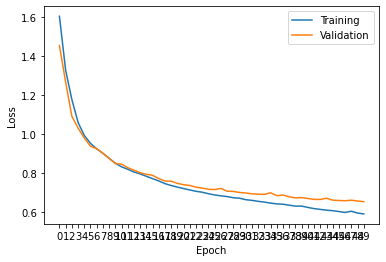


Finished Training, Testing on test set


100%|██████████| 114/114 [00:02<00:00, 49.86it/s]



 0.7636883298033162

Generating Unlabeled Result


100%|██████████| 114/114 [00:01<00:00, 85.93it/s]


AP = 0.5634031173126235
AP = 0.6284943909299082
AP = 0.17019388734228877
AP = 0.8029671928227727
AP = 0.3839983105387548
Average Precision (all classes) = 0.5098113797892696
CPU times: user 20min 19s, sys: 9.21 s, total: 20min 28s
Wall time: 20min 31s


In [10]:
%%time
criterion = nn.CrossEntropyLoss()
##############################################################################
# TODO: Modify the lines below to experiment with different optimizers,      #
# parameters (such as learning rate) and number of epochs.                   #
##############################################################################
optimizer = torch.optim.Adam(net.parameters(), 5e-4, weight_decay=1e-5)
num_epoch = 50
##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################

print('\nStart training')
trn_hist = []
val_hist = []
for epoch in range(num_epoch): #TODO: Change the number of epochs
  print('-----------------Epoch = %d-----------------' % (epoch+1))
  trn_loss = train(train_loader, net, criterion, optimizer, device, epoch+1)
  print('Validation loss: ')
  val_loss = test(val_loader, net, criterion, device)
  trn_hist.append(trn_loss)
  val_hist.append(val_loss)

plot_hist(trn_hist, val_hist)
##########################################################################
# TODO: Submit the "Average Precision(all classes)" value in the report  #
##########################################################################
print('\nFinished Training, Testing on test set')
test(test_loader, net, criterion, device)
print('\nGenerating Unlabeled Result')
##############################################################################
# You can visualize your segmentation results using get_results function     #
# Your result will be dumped in the folder 'output_test'.                    #
# There will be three files for each image:                                   # 
#   (1) gt<num>.png (ground truth label)                                     #
#   (2) x<num>.png (input RGB image)                                         #
#   (3) y<num>.png (predicted output)                                        #
#                                                                            #
# TODO: Find a satisfactory result by running the next cell and report       #
#       the plot of gt<num>.png, x<num>.png and y<num>.png in the pdf        #
# Note: Your submission doesn't have to be perfect.                          #
##############################################################################
result = get_result(test_loader, net, device, folder='output_test')

os.makedirs('./models', exist_ok=True)
torch.save(net.state_dict(), './models/model_{}.pth'.format(name))

cal_AP(ap_loader, net, criterion, device)

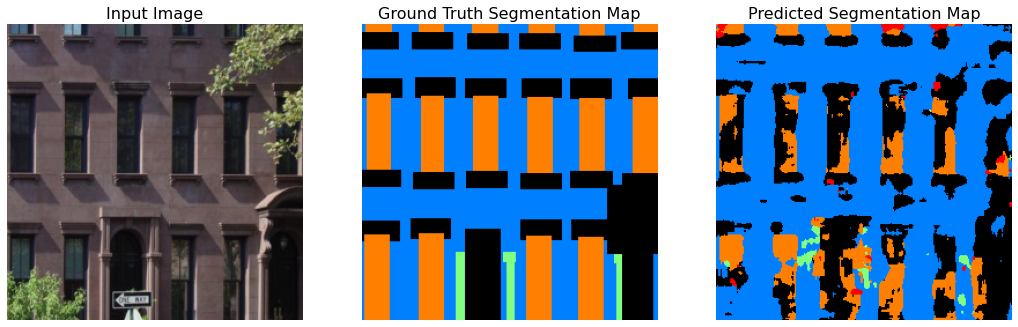

In [11]:
########################################################################
# TODO: Find a satisfactory result from the 114 test images            #
#       Submit the result in the pdf                                   #
# Note: Your submission doesn't have to be perfect.                    #
########################################################################
img_idx = 0
########################################################################
#                             END OF YOUR CODE                         #
########################################################################
output_dir = 'output_test'

plt.subplot(1, 3, 1)
plt.imshow(Image.open(os.path.join(output_dir, 'x{}.png'.format(img_idx))))
plt.title('Input Image', fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(Image.open(os.path.join(output_dir, 'gt{}.png'.format(img_idx))))
plt.title('Ground Truth Segmentation Map', fontsize=16)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(Image.open(os.path.join(output_dir, 'y{}.png'.format(img_idx))))
plt.title('Predicted Segmentation Map', fontsize=16)
plt.axis('off')

plt.gcf().set_size_inches(18, 10)
plt.show()

## Acknowledgement
The Mini Facade dataset are modified from CMP Facade Database by $Radim \ Tyle \check{c}ek$ and $Radim \ \check{S}a^{'}ra$. Please feel free to similarly re-use our problems while similarly crediting us.